# General Information

![](https://raw.githubusercontent.com/tensorflow/tpu/master/models/official/efficientnet/g3doc/params.png)

This was my first experience of direct interaction with neural networks, which I received in the Data Science course from SkillFactory. The legend was that we had a dataset with photos of cars from 10 categories. The task was to select, customize and fine-tune the pre-trained SOTA model for the most accurate category projections.

# 1. Initial Setup

In [1]:
# Checking the GPU.
!nvidia-smi

Tue Mar 23 17:19:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.51.06    Driver Version: 450.51.06    CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    29W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Let's install the update for TensorFlow, the ImageDataAugmentor custom image generator, and the EfficientNet neural network.

In [2]:
# Installing the modules.
!pip install tensorflow --upgrade
!pip install git+https://github.com/mjkvaak/ImageDataAugmentor
!pip install efficientnet

  Cloning https://github.com/mjkvaak/ImageDataAugmentor to /tmp/pip-req-build-agv_e60b
  Running command git clone -q https://github.com/mjkvaak/ImageDataAugmentor /tmp/pip-req-build-agv_e60b
  Created wheel for ImageDataAugmentor: filename=ImageDataAugmentor-0.0.0-py3-none-any.whl size=29531 sha256=868c6e7dea6e1f8be8a5662d768ee1ca54a84f7bba70e54035d5c31be3254339
  Stored in directory: /tmp/pip-ephem-wheel-cache-20lg5xc6/wheels/c9/bd/73/9cfa59d2393dae55bbcc30f5aa901f55fe531c66efebbc8fc3
Successfully built ImageDataAugmentor
     |████████████████████████████████| 50 kB 771 kB/s eta 0:00:01


In [3]:
# Importing modules.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as layers
import efficientnet.tfkeras as efn
import PIL
import albumentations
import pickle
import zipfile
import csv
import sys
import os
import shutil

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint, Callback, ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.applications import EfficientNetB7
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import accuracy_score
from ImageDataAugmentor.image_data_augmentor import *
from PIL import ImageOps, ImageFilter
from pylab import rcParams
from keras import backend as K

rcParams['figure.figsize'] = 10, 5
%config InlineBackend.figure_format = 'svg' 
%matplotlib inline

print(os.listdir("../input/sf-dl-car-classification"))
print('Python       :', sys.version.split('\n')[0])
print('Numpy        :', np.__version__)
print('Tensorflow   :', tf.__version__)
print('Keras        :', tf.keras.__version__)

['train.zip', 'sample-submission.csv', 'test.zip', 'train.csv']
Python       : 3.7.9 | packaged by conda-forge | (default, Dec  9 2020, 21:08:20) 
Numpy        : 1.19.5
Tensorflow   : 2.4.1
Keras        : 2.4.0


In [4]:
# Setting the conditions.
EPOCHS = 10
BATCH_SIZE = 32
LR = 1e-3
VAL_SPLIT = 0.2
CLASS_NUM = 10
IMG_SIZE = 224
IMG_CHANNELS = 3
RANDOM_SEED = 42
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, IMG_CHANNELS)

DATA_PATH = '../input/sf-dl-car-classification/'
PATH = "../working/car/"

!pip3 freeze > requirements.txt

In [5]:
# Importing datasets.
train_df = pd.read_csv(DATA_PATH+"train.csv")
sample_submission = pd.read_csv(DATA_PATH+"sample-submission.csv")

# 2. Exploratory Data Analysis

In [6]:
# Checking the data.
train_df.head()
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15561 entries, 0 to 15560
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Id        15561 non-null  object
 1   Category  15561 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 243.3+ KB


<AxesSubplot:>

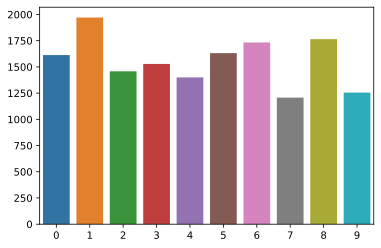

In [7]:
# Checking the frequency distribution.
sns.barplot(y=train_df.Category.value_counts().values,
            x=train_df.Category.value_counts().index)

In [8]:
# Unpacking images.
for data_zip in ['train.zip', 'test.zip']:
    with zipfile.ZipFile("../input/sf-dl-car-classification/"+data_zip,"r") as z:
        z.extractall(PATH)

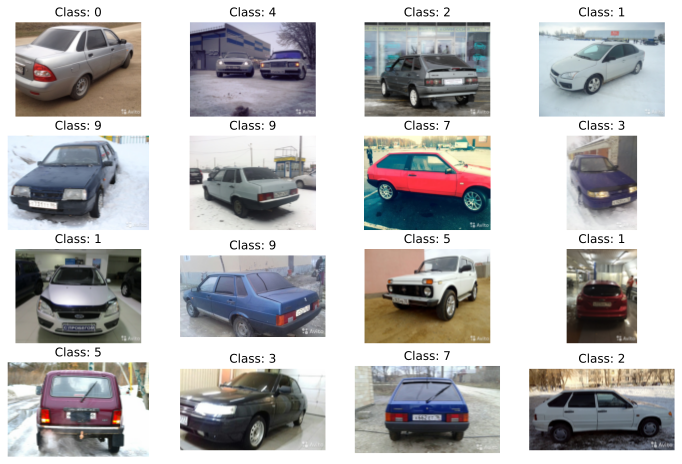

In [9]:
# Checking images.
plt.figure(figsize=(12,8))

random_image = train_df.sample(n=16)
random_image_paths = random_image['Id'].values
random_image_cat = random_image['Category'].values

for index, path in enumerate(random_image_paths):
    im = PIL.Image.open(PATH+f'train/{random_image_cat[index]}/{path}')
    plt.subplot(4,4, index+1)
    plt.imshow(im)
    plt.title('Class: '+str(random_image_cat[index]))
    plt.axis('off')
plt.show()

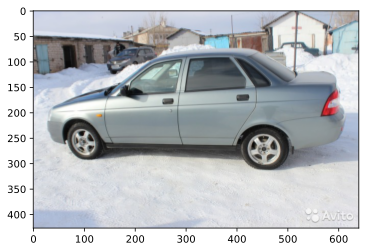

(640, 427)

In [10]:
# Checking images.
image = PIL.Image.open(PATH+'/train/0/100155.jpg')
imgplot = plt.imshow(image)
plt.show()
image.size

Let's summarize:

* Photos are divided into 10 roughly equal-sized categories;
* These are colored photos of 640 by 480 pixels (mostly)
* There are 15561 photos in the training dataset, and 6675 photos in the test dataset.

This number of photos is not enough to train our neural network, so let's use augmentation.

# 3. Data Pre-processing

Let's use the IDA image generator and the Albumentations library, which sets hyperparameters for it (rotation angle, crop size, brightness, etc).

In [11]:
# Setting the conditions for augmentation.
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, 
                          interpolation=1, 
                          border_mode=4, 
                          value=None, 
                          mask_value=None, 
                          always_apply=False, 
                          p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, 
                                  width=200),
        albumentations.CenterCrop(height=200, 
                                  width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, 
                            always_apply=False, 
                            p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

In [12]:
# Data loaders.
train_datagen = ImageDataAugmentor(
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT
)

test_datagen = ImageDataGenerator(
    rescale=1./255
)

In [13]:
# Data generators.
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation'
)

/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:332: UserWarning: Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_directory` has been been removed: pass  `seed` '


Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


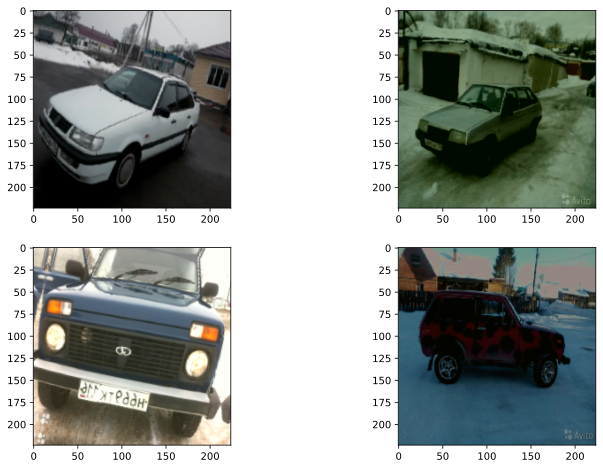

In [14]:
# Checking images.
x,y = train_generator.next()

plt.figure(figsize=(12,8))

for i in range(0,4):
    image = x[i]
    plt.subplot(2,2, i+1)
    plt.imshow(image)
plt.show()

# 4. Machine Learning

## 4.1 Basic Model

Let's load the EfficientNet B7 model.

In [15]:
# Loading the model.
base_model = efn.EfficientNetB7(
    weights='imagenet',
    include_top=False,
    input_shape=INPUT_SHAPE
)

258441216/258434480 [==============================] - 3s 0us/step


In [16]:
# Checking the model.
base_model.summary()

Model: "efficientnet-b7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 112, 112, 64) 1728        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 112, 112, 64) 256         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 112, 112, 64) 0           stem_bn[0][0]                    
____________________________________________________________________________________

__________________________________________________________________________________________________
block6j_se_squeeze (GlobalAvera (None, 2304)         0           block6j_activation[0][0]         
__________________________________________________________________________________________________
block6j_se_reshape (Reshape)    (None, 1, 1, 2304)   0           block6j_se_squeeze[0][0]         
__________________________________________________________________________________________________
block6j_se_reduce (Conv2D)      (None, 1, 1, 96)     221280      block6j_se_reshape[0][0]         
__________________________________________________________________________________________________
block6j_se_expand (Conv2D)      (None, 1, 1, 2304)   223488      block6j_se_reduce[0][0]          
__________________________________________________________________________________________________
block6j_se_excite (Multiply)    (None, 7, 7, 2304)   0           block6j_activation[0][0]         
          

Let's freeze the weights in the base model, so we cannot erase the features obtained on ImageNet at the beginning of training.

In [17]:
# Freezing the weights.
base_model.trainable = False

Now let's install a new "head" containing the output information. First of all, we will consolidate all features to the single vector via Average Pooling layer.

In [18]:
# Adding layers.
model = Sequential()
model.add(base_model)
model.add(layers.GlobalAveragePooling2D(),)

Now let's experiment a little with the architecture. We will add another fully connected dense, batch normalization, dropout and output layers.

In [19]:
# Adding layers.
model.add(layers.Dense(256, activation='relu'))
model.add(layers.BatchNormalization())
model.add(layers.Dropout(0.25))
model.add(layers.Dense(CLASS_NUM, activation='softmax'))

In [20]:
# Checking the model.
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b7 (Functional) (None, 7, 7, 2560)        64097680  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2560)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               655616    
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 64,756,890
Trainable params: 658,698
Non-trainable params: 64,098,192
______________________________________

In [21]:
# Check the trainable status of the individual layers.
for layer in model.layers:
    print(layer, layer.trainable)

<tensorflow.python.keras.engine.functional.Functional object at 0x7f8868091f10> False
<tensorflow.python.keras.layers.pooling.GlobalAveragePooling2D object at 0x7f88582b41d0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f87f022ff50> True
<tensorflow.python.keras.layers.normalization_v2.BatchNormalization object at 0x7f87f021f650> True
<tensorflow.python.keras.layers.core.Dropout object at 0x7f87f0237cd0> True
<tensorflow.python.keras.layers.core.Dense object at 0x7f87f0232a10> True


Let's add quality and error metrics, as well as the Adam learning rate optimization algorithm.

In [22]:
# Compiling the model.
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

Let's add some callback functions. ModelCheckpoint will allow us to save the model's learning progress. EarlyStopping stops training if the quality metric does not grow during the number of epochs equal to the 'patience' parameter. ReduceLROnPlateau reduces the learning rate if the loss metric does not fall during the number of epochs equal to the 'patience'parameter.

In [23]:
# Callback functions.
checkpoint = ModelCheckpoint(
    'best_model.hdf5',
    monitor=['val_accuracy'],
    verbose=1,
    mode='max'
)

earlystop = EarlyStopping(
    monitor='accuracy',
    patience=5,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.25,
    patience=2,
    min_lr=0.0000001,
    verbose=1,
    mode='auto'
)

callbacks_list = [
    checkpoint,
    earlystop,
    reduce_lr
]

In [24]:
# Neural network training.
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=valid_generator, 
        validation_steps=valid_generator.samples//valid_generator.batch_size,
        epochs=EPOCHS,
        callbacks=callbacks_list
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
389/389 [==============================] - 211s 490ms/step - loss: 2.0596 - accuracy: 0.3281 - val_loss: 1.1403 - val_accuracy: 0.5954

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
389/389 [==============================] - 184s 473ms/step - loss: 1.4940 - accuracy: 0.4815 - val_loss: 1.0568 - val_accuracy: 0.6240

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
389/389 [==============================] - 183s 470ms/step - loss: 1.3887 - accuracy: 0.5014 - val_loss: 1.0221 - val_accuracy: 0.6311

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
389/389 [==============================] - 182s 467ms/step - loss: 1.3262 - accuracy: 0.5207 - val_loss: 0.9679 - val_accuracy: 0.6469

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
389/389 [==============================] - 183s 471ms/step - loss: 1.2995 - accuracy: 0.5370 - val_loss: 0.9570 - val_accuracy: 0.6627

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
389/389 [====================

Let's save the resulting network and load the weights from the best iteration so far (best_model).

In [25]:
# Saving model + Loading best weights.
model.save('../working/model_step1.hdf5')
model.load_weights('best_model.hdf5')

Now let's check the accuracy of our model and look at the training plots.

In [26]:
# Checking the accuracy.
scores = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1877: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


98/98 [==============================] - 37s 371ms/step - loss: 0.8474 - accuracy: 0.7005
Accuracy: 70.05%


## Accuracy at this stage: 70.05%

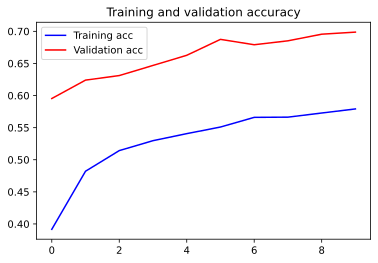

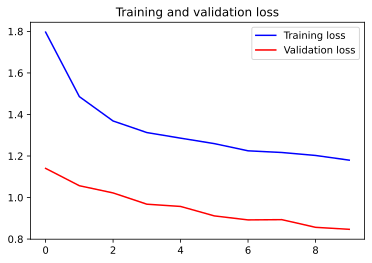

In [27]:
# Checking the plots.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss'] 
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
 
plt.show()

## 4.2 Fine-tuning (half of the network)

Let's start by unfreezing and training only half of the weights.

In [28]:
# Unfreeze all layers.
base_model.trainable = True

# Fine-tune from this layer onwards.
fine_tune_at = len(base_model.layers)//2

# Freeze all the layers before the `fine_tune_at` layer.
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

In [29]:
# Compiling the model.
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [30]:
# Neural network training.
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=valid_generator, 
        validation_steps=valid_generator.samples//valid_generator.batch_size,
        epochs=EPOCHS,
        callbacks=callbacks_list
)

Epoch 1/10
389/389 [==============================] - 247s 575ms/step - loss: 1.3406 - accuracy: 0.5507 - val_loss: 0.5856 - val_accuracy: 0.8099

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
389/389 [==============================] - 221s 567ms/step - loss: 0.4720 - accuracy: 0.8381 - val_loss: 0.3471 - val_accuracy: 0.8750

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
389/389 [==============================] - 220s 566ms/step - loss: 0.3690 - accuracy: 0.8697 - val_loss: 0.2813 - val_accuracy: 0.8985

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
389/389 [==============================] - 221s 566ms/step - loss: 0.3073 - accuracy: 0.8907 - val_loss: 0.2199 - val_accuracy: 0.9224

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
389/389 [==============================] - 221s 568ms/step - loss: 0.2595 - accuracy: 0.9065 - val_loss: 0.2894 - val_accuracy: 0.9050

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
389/389 [====================

In [31]:
# Saving model + Loading best weights.
model.save('../working/model_step2.hdf5')
model.load_weights('best_model.hdf5')

In [32]:
# Checking the accuracy.
scores = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

98/98 [==============================] - 37s 374ms/step - loss: 0.1455 - accuracy: 0.9524
Accuracy: 95.24%


## Accuracy at this stage: 95.24%

## 4.3 Fine-tuning (whole network)

Let's reduce the batch size and update our data generators, otherwise our network will not fit into the GPU RAM.

In [33]:
# Lowering the batch size.
BATCH_SIZE = 8

In [34]:
# Unfreeze all layers.
base_model.trainable = True

In [35]:
# Data generators.
train_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    seed=RANDOM_SEED,
    subset='training'
)

valid_generator = train_datagen.flow_from_directory(
    PATH+'train/',
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True, 
    seed=RANDOM_SEED,
    subset='validation'
)

Found 12452 images belonging to 10 classes.
Found 3109 images belonging to 10 classes.


In [36]:
# Compiling the model.
model.compile(
    loss="categorical_crossentropy",
    optimizer=optimizers.Adam(lr=LR),
    metrics=["accuracy"]
)

In [37]:
# Neural network training.
history = model.fit_generator(
        train_generator,
        steps_per_epoch=train_generator.samples//train_generator.batch_size,
        validation_data=valid_generator, 
        validation_steps=valid_generator.samples//valid_generator.batch_size,
        epochs=EPOCHS,
        callbacks=callbacks_list
)

Epoch 1/10
1556/1556 [==============================] - 633s 389ms/step - loss: 0.8565 - accuracy: 0.7346 - val_loss: 2.0137 - val_accuracy: 0.3611

Epoch 00001: saving model to best_model.hdf5
Epoch 2/10
1556/1556 [==============================] - 602s 387ms/step - loss: 0.7023 - accuracy: 0.7696 - val_loss: 0.4175 - val_accuracy: 0.8628

Epoch 00002: saving model to best_model.hdf5
Epoch 3/10
1556/1556 [==============================] - 603s 388ms/step - loss: 0.4599 - accuracy: 0.8452 - val_loss: 0.4337 - val_accuracy: 0.8647

Epoch 00003: saving model to best_model.hdf5
Epoch 4/10
1556/1556 [==============================] - 603s 388ms/step - loss: 0.4353 - accuracy: 0.8534 - val_loss: 0.3142 - val_accuracy: 0.8956

Epoch 00004: saving model to best_model.hdf5
Epoch 5/10
1556/1556 [==============================] - 603s 387ms/step - loss: 0.3896 - accuracy: 0.8713 - val_loss: 0.3508 - val_accuracy: 0.8734

Epoch 00005: saving model to best_model.hdf5
Epoch 6/10
1556/1556 [========

In [38]:
# Saving model + Loading best weights.
model.save('../working/model_step3.hdf5')
model.load_weights('best_model.hdf5')

In [39]:
# Checking the accuracy.
scores = model.evaluate_generator(valid_generator, steps=len(valid_generator), verbose=1)
print("Accuracy: %.2f%%" % (scores[1]*100))

389/389 [==============================] - 41s 104ms/step - loss: 0.2657 - accuracy: 0.9083
Accuracy: 90.83%


## Accuracy at this stage: 90.83%

# 5. Prediction

Now let's use our trained network to predict the categories on the test dataset.

In [40]:
# Data generator.
test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False,
    seed=RANDOM_SEED
)

Found 6675 validated image filenames.


In [41]:
# Checking the data.
test_generator.samples

6675

In [42]:
# Predicting the data.
test_generator.reset()

predictions = model.predict_generator(
    test_generator, 
    steps=len(test_generator), 
    verbose=1
) 

predictions = np.argmax(
    predictions, 
    axis=-1)

label_map = (train_generator.class_indices)

label_map = dict((v,k) for k,v in label_map.items())

predictions = [label_map[k] for k in predictions]

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


835/835 [==============================] - 69s 78ms/step


In [43]:
# Setting up a submission.
filenames_with_dir = test_generator.filenames

submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')

submission.to_csv('submission.csv', index=False)

## Accuracy at this stage: 95.76%

# 6. Test Time Augmentation (TTA)

Let's augment the test images and make several predictions of the same image augumented in a different ways. Then we will take the average of these predictions and thus get the final prediction.

In [44]:
# Loading best weights.
model.load_weights('best_model.hdf5')

In [45]:
# Setting the conditions for augmentation.
AUGMENTATIONS = albumentations.Compose([
    albumentations.HorizontalFlip(p=0.5),
    albumentations.Rotate(limit=30, 
                          interpolation=1, 
                          border_mode=4, 
                          value=None, 
                          mask_value=None, 
                          always_apply=False, 
                          p=0.5),
    albumentations.OneOf([
        albumentations.CenterCrop(height=224, 
                                  width=200),
        albumentations.CenterCrop(height=200, 
                                  width=224),
    ],p=0.5),
    albumentations.OneOf([
        albumentations.RandomBrightnessContrast(brightness_limit=0.3, 
                                                contrast_limit=0.3),
        albumentations.RandomBrightnessContrast(brightness_limit=0.1, 
                                                contrast_limit=0.1)
    ],p=0.5),
    albumentations.GaussianBlur(p=0.05),
    albumentations.HueSaturationValue(p=0.5),
    albumentations.RGBShift(p=0.5),
    albumentations.FancyPCA(alpha=0.1, 
                            always_apply=False, 
                            p=0.5),
    albumentations.Resize(IMG_SIZE, IMG_SIZE)
])

In [46]:
# Data loader.
test_datagen = ImageDataAugmentor( 
    rescale=1./255,
    augment=AUGMENTATIONS,
    validation_split=VAL_SPLIT,
)

In [47]:
# Data generator.
test_generator = test_datagen.flow_from_dataframe(
    dataframe=sample_submission,
    directory=PATH+'test_upload/',
    x_col="Id",
    y_col=None,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode=None,
    shuffle=False,
    seed=RANDOM_SEED
)

Found 6675 validated image filenames.


/opt/conda/lib/python3.7/site-packages/ImageDataAugmentor/image_data_augmentor.py:455: UserWarning: Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` as parameter in `ImageDataAugmentor(..., seed=...)` instead
  warnings.warn('Passing `seed` in `.flow_from_datagrame` has been been removed: pass  `seed` '


In [ ]:
# Predicting the data.
tta_steps = 10 
predictions = []

for i in range(tta_steps):
    preds = model.predict_generator(test_generator, 
                                    steps=len(test_generator), 
                                    verbose=1) 
    predictions.append(preds)

pred = np.mean(predictions, axis=0)

predictions = np.argmax(pred, axis=-1)

label_map = (train_generator.class_indices)

label_map = dict((v,k) for k,v in label_map.items())

predictions = [label_map[k] for k in predictions]

781/835 [===========================>..] - ETA: 5s

In [ ]:
# Setting up a submission.
filenames_with_dir=test_generator.filenames

submission = pd.DataFrame({'Id':filenames_with_dir, 'Category':predictions}, 
                          columns=['Id', 'Category'])

submission['Id'] = submission['Id'].replace('test_upload/','')

submission.to_csv('submission_TTA.csv', index=False)

## Final accuracy: 96.13%

In [ ]:
# Cleaning the data.
shutil.rmtree(PATH)

# 7. Recap & Conclusions

Let's follow the actions taken:

* We initialized necessary libraries, set visualization conditions and loaded the dataset.
* We configured hyperparameters: number of epochs, batch size, learning rate, validation sample ratio and image size.
* We have augmented our images in several ways, thus increasing the sample size.
* We loaded the pre-trained EfficientNet B7 model, changed the "head", added a batch normalization layer and the Adam learning rate optimizer.
* We have set up callback functions to save intermediate progress, stop if there is no progress on the quality metric, and slow down the learning rate if there is no progress on the loss metric.
* We trained our model three times - with the frozen weights pre-trained on ImageNet, with half the weights, and with all the weights.
* We predicted our data in a standard way and using Test Time Augmentation.

The following conclusions can be drawn from the results:

* Increasing the number of epochs improves the result, if you do not bring it to the overfitting.
* Reducing the batch size increases the time of the experiment, but it hepls to avoid RAM errors.
* Low learning rate slows down the experiment, but it helps to avoids local minimums.
* Large image size slows down the experiment and overloads RAM, but gives more features.
* Image augmentation is a good tool for increasing the sample size.
* Step-by-step training improves outcomes, but there was no significant difference between a half-trained and a fully-trained network.
* It is crucial to monitor the size of the batch, otherwise network training can be interrupted by RAM error.
* Test Time Augmentation really improves the prediction result.
* It is necessary to clear the output directory on Kaggle, otherwise your progress may not be saved.